In [1]:
pip install numpy scipy librosa scikit-learn matplotlib tensorflow joblib

In [2]:
import os
import glob
import random
import numpy as np
import librosa
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [3]:
from google.colab import files
uploaded = files.upload()

Saving RP1 Heart data.zip to RP1 Heart data.zip


In [4]:
import zipfile
with zipfile.ZipFile("/content/RP1 Heart data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_PATH = "/content/RP Heart data/Heart_data"
SAMPLE_RATE = 2000
MIN_DURATION = 2.0
N_MFCC = 40
MAX_PAD_LEN = 400
AUG_PER_SAMPLE = 2
TEST_SIZE = 0.15
VAL_SIZE = 0.15
BATCH_SIZE = 16
EPOCHS = 80
MODEL_SAVE_PATH = "best_model.keras"
FINAL_MODEL_PATH = "final_heartbeat_model.keras"
LABEL_ENCODER_PATH = "label_encoder.joblib"

In [6]:
def bandpass_filter(signal, sr, lowcut=20.0, highcut=450.0, order=4):
    nyq = 0.5 * sr
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def time_stretch(y, rate):
    try:
        return librosa.effects.time_stretch(y, rate)
    except Exception:
        return y

def pitch_shift(y, sr, n_steps):
    try:
        return librosa.effects.pitch_shift(y, sr, n_steps)
    except Exception:
        return y

def shift_time(y, shift_max=0.1):
    shift = int(random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

def load_and_preprocess(path, sr=SAMPLE_RATE, pad_duration=MIN_DURATION):
    y, orig_sr = librosa.load(path, sr=None, mono=True)
    if orig_sr != sr:
        y = librosa.resample(y=y, orig_sr=orig_sr, target_sr=sr) # Corrected arguments
    y = bandpass_filter(y, sr)
    target_len = int(pad_duration * sr)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode="constant")
    else:
        y = y[:target_len]
    return y

def extract_mfcc_from_audio(y, sr=SAMPLE_RATE, n_mfcc=N_MFCC, max_len=MAX_PAD_LEN):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=1024, hop_length=256)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

In [9]:
def build_dataset(dataset_path=DATASET_PATH, augment=AUG_PER_SAMPLE):
    X, y = [], []
    if not os.path.exists(dataset_path):
        print(f" Error: Audio data directory not found at {dataset_path}")
        return np.array([]), np.array([]), []

    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(" Found classes:", classes)

    for cls in classes:
        cls_dir = os.path.join(dataset_path, cls)
        files = glob.glob(os.path.join(cls_dir, "*.wav"))
        print(f"Class {cls}: {len(files)} files")

        for fpath in files:
            try:
                audio = load_and_preprocess(fpath)
                mf = extract_mfcc_from_audio(audio)
                X.append(mf); y.append(cls)

                # augment (only on training later)
                for _ in range(augment):
                    aug = audio.copy()
                    if random.random() < 0.5:
                        aug = add_noise(aug, noise_factor=random.uniform(0.002, 0.01))
                    if random.random() < 0.5:
                        rate = random.uniform(0.92, 1.08)
                        aug = time_stretch(aug, rate)
                        if len(aug) < int(MIN_DURATION * SAMPLE_RATE):
                            aug = np.pad(aug, (0, int(MIN_DURATION * SAMPLE_RATE) - len(aug)), mode="constant")
                        else:
                            aug = aug[:int(MIN_DURATION * SAMPLE_RATE)]
                    if random.random() < 0.4:
                        aug = pitch_shift(aug, SAMPLE_RATE, n_steps=random.uniform(-1.0, 1.0))
                    if random.random() < 0.3:
                        aug = shift_time(aug, shift_max=0.05)
                    aug = bandpass_filter(aug, SAMPLE_RATE)
                    mf_aug = extract_mfcc_from_audio(aug)
                    X.append(mf_aug); y.append(cls)
            except Exception as e:
                print(" Error reading", fpath, e)

    X, y = np.array(X), np.array(y)
    print(" Built dataset shapes:", X.shape, y.shape)
    return X, y, classes


In [10]:
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model



In [11]:
def train_model(X, y, le):
    y_encoded = le.transform(y)
    y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(le.classes_))
    X = np.expand_dims(X, -1)


    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.15, random_state=SEED, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=SEED, stratify=np.argmax(y_train,1))

    print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

    model = create_model(input_shape=X.shape[1:], num_classes=len(le.classes_))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
    rl = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rl],
        verbose=1
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f" Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # Save model
    model.save(FINAL_MODEL_PATH,save_format = "keras")
    print(f" Model saved at {FINAL_MODEL_PATH}")

    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.legend(); plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.legend(); plt.title("Loss")
    plt.show()

    return model


 Found classes: ['AS', 'MR', 'MS', 'MVP', 'N']
Class AS: 200 files
Class MR: 200 files
Class MS: 200 files
Class MVP: 200 files
Class N: 200 files
 Built dataset shapes: (3000, 40, 400) (3000,)
 Label classes: ['AS' 'MR' 'MS' 'MVP' 'N']
Train: (2167, 40, 400, 1) Val: (383, 40, 400, 1) Test: (450, 40, 400, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.2387 - loss: 1.5965 - val_accuracy: 0.1984 - val_loss: 1.5359 - learning_rate: 0.0010
Epoch 2/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5638 - loss: 1.0967 - val_accuracy: 0.6136 - val_loss: 1.1253 - learning_rate: 0.0010
Epoch 3/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7183 - loss: 0.8081 - val_accuracy: 0.7467 - val_loss: 0.7371 - learning_rate: 0.0010
Epoch 4/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7892 - loss: 0.6538 - val_accuracy: 0.8486 - val_loss: 0.5711 - learning_rate: 0.0010
Epoch 5/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8310 - loss: 0.5209 - val_accuracy: 0.8042 - val_loss: 0.6081 - learning_rate: 0.0010
Epoch 6/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8572 - loss: 0.4291 - val_accuracy: 0.8773 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 7/80
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8565 - loss: 0

 Test Accuracy: 0.9956, Test Loss: 0.0185
 Model saved at final_heartbeat_model.keras


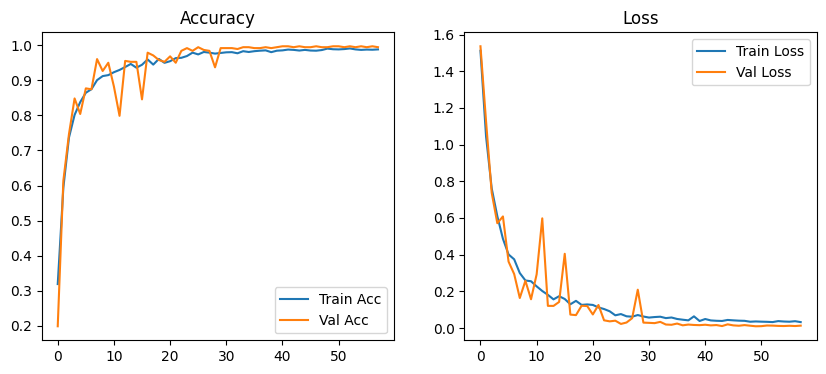

In [12]:
if __name__ == "__main__":
    X, y, classes = build_dataset(DATASET_PATH)
    if X.shape[0] == 0:
        raise ValueError("Dataset is empty. Check your DATASET_PATH!")

    le = LabelEncoder(); le.fit(y)
    joblib.dump(le, LABEL_ENCODER_PATH)
    print(" Label classes:", le.classes_)

    model = train_model(X, y, le)